# Get Vegetation Tree Height Polygons
Assign value for client name — this will label the reports.

Generate a token following the directions [here](https://ibm.github.io/Environmental-Intelligence-Suite/api-tokens.html) and paste the token into the quotes for `AUTH_TOKEN` below.

___

___

In [37]:
client = 'Demo'

In [49]:
AUTH_TOKEN = ''

___

## Import Libraries and Define Functions

In [50]:
import os
import json
import requests
from IPython.display import Image
from datetime import datetime as dt

In [51]:
API_ENDPOINT = 'foundation.agtech.ibm.com/v2'
os.environ["API_ENDPOINT"] = API_ENDPOINT
os.environ["AUTH_TOKEN"]= AUTH_TOKEN

ASSET_MGMT = {
    'host': os.environ.get('API_ENDPOINT', 'Run the notebook to set env vars')
}

HEADERS = {
    'Accept': 'application/json',
    'Authorization': 'Bearer ' + os.environ.get("AUTH_TOKEN", 'Run the notebook to set env vars'),
    'Content-Type': 'application/json; charset=UTF-8'
}

In [52]:
def getScalarType(scalar_type=None):
    get_url = 'https://{}/scalar/type'.format(ASSET_MGMT['host'])
    
    params = {}
    
    if scalar_type is not None:
        params['type'] = scalar_type
    
    r = requests.get(url=get_url, headers=HEADERS,  params=params) 
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()


def getHierarchy():
    get_url = 'https://{}/hierarchy'.format(ASSET_MGMT['host'])
    
    r = requests.get(url=get_url, headers=HEADERS)
    return json.loads(r.text) if (r.status_code == 200) else r.raise_for_status()


def getAsset(input_type=None, parentID=None, limit=1000, start=0, idsOnly=False, includeScalars=False, includeGeom=False, assets=None, firstRun=True, assetCount=None, showCount=True):
    
    if firstRun:
        assetCount = 0
        assets = {
            'features': []
        }
    
    params = {
        'start': start,
        'idsOnly': idsOnly,
        'includeAssetGeometry': includeGeom
    }
    
    if input_type is not None:
        params['inputType'] = input_type
        
    if parentID is not None:
        params['parentReferenceUuid'] = parentID

    if includeScalars is True:
        params['includeScalarInfo'] = includeScalars

    get_url = ('https://{}/asset?projection=4326&limit=' + str(limit)).format(ASSET_MGMT['host'])
    r = requests.get(url=get_url, headers=HEADERS, params=params)
    
    if (r.status_code == 200):
        response = json.loads(r.text)
        assets['features'].extend(response['features'])
        assetCount = assetCount + len(response['features'])

        if showCount:
            print('Assets retrieved so far:', assetCount)
        
        if len(response['features']) < limit:
            return assets
        
        else:
            return getAsset(input_type=input_type, parentID=parentID, limit=limit, start=start+limit, idsOnly=idsOnly, includeScalars=includeScalars, includeGeom=includeGeom, assets=assets, firstRun=False, assetCount=assetCount, showCount=showCount)
    
    else:
        r.raise_for_status()


def postSearchVectorBBox(box, vector_jsons={'features': []}, vector_uuids=[], start=0, limit=1000):

    data = {
        'matchMode': 'CONTAINS',
        'bufferSize': 100,
        'boundingBox': box,
        'start': start,
        'limit': limit
    }

    data = json.dumps(data)
    post_url = 'https://{}/vectordata/search/box'.format(ASSET_MGMT['host'])
    r = requests.post(url = post_url, data = data, headers = HEADERS)

    
    if (r.status_code == 200):
        
        vector_data = json.loads(r.text)['features']
                
        for vector in vector_data:
            if vector['uuid'] not in vector_uuids:
                vector_uuids.append(vector['uuid'])
                vector_jsons['features'].append(vector)

        if len(vector_data) < limit:
            print('Final batch of vectors for given territory — total retrieved:', len(vector_uuids))
            return(vector_jsons)

        elif len(vector_data) == limit:
            print('Vectors retrieved so far:', len(vector_uuids))
            return postSearchVectorBBox(box, vector_jsons, vector_uuids, start=start+limit, limit=limit)
        
    else:
        r.raise_for_status()


def postReportJob(job_name, job_params_list, inputType, territory_name=None, scalar_data=True, wkt_geom=True, limit=1):
    
    post_url = 'https://{}/report/job'.format(ASSET_MGMT['host'])
    
    data = {
        'jobName': job_name,
        'jobType': 'ASSET_SEARCH',
        'jobRequest': {
            'inputType': inputType,
            'nameMatch': 'STARTS_WITH',
            'includeScalarInfo':  scalar_data,
            'projection': 4326,
            'uuidsOnly': False,
            'start': 0
        },
        'jobParams': job_params_list
    }
    
    if territory_name is not None:
        data['properties'] = {
            'DISTRICT_I': [territory_name]
        }
    
    if wkt_geom:
        data['jobParams'].append('geometry')
    
    data = json.dumps(data)
    r = requests.post(url = post_url, data = data, headers = HEADERS) 
    return json.loads(r.text)


def getVectorData():

    start = dt.now()
    all_vectors = {'features': []}
    all_vector_uuids = []
    repeat_uuids = []
    
    print('Initiating request to get all vector data...')

    for territory in territories['features']:
        print('\nGetting vectors for territory:', territory['properties']['name'])
        bbox = territory['properties']['box']
        terr_vectors = postSearchVectorBBox(bbox, vector_jsons={'features': []}, vector_uuids=[])
        
        for vector in terr_vectors['features']:
            if vector['uuid'] not in all_vector_uuids:
                all_vector_uuids.append(vector['uuid'])
                all_vectors['features'].append(vector)
            elif vector['uuid'] in all_vector_uuids:
                repeat_uuids.append(vector['uuid'])

    print('\nRequest Complete. Elapsed Time:', dt.now()-start)
    print('Unique Vectors:', len(all_vectors['features']))
    print('Repeat Vectors:', len(repeat_uuids))
    
    return(all_vectors)

___

___

## Fetch Vegetation Polygons

### 1. First, get all territories

In [42]:
territories = getAsset('TERRITORY')

Assets retrieved so far: 2


In [43]:
terr_count = 0
all_territories = []
for territory in territories['features']:
    all_territories.append(territory)
    print('Territory Name:',territory['properties']['name'])    
    print('Territory UUID:', territory['uuid'])
    print('Index:', terr_count)
    terr_count = terr_count + 1
    print('\n')

Territory Name: NAPERVILLE_NORTH
Territory UUID: fa601936-4ce8-4054-8e17-84b5746febd3
Index: 0


Territory Name: NAPERVILLE_SOUTH
Territory UUID: c33c5a6b-439a-4b91-96fd-d6f537ccc733
Index: 1




___

### 2. Get Vector Data for One Territory
The default here is getting data from the first territory in the list above; this can be changed by updating the numerical value in the brackets.

In [44]:
single_territory = all_territories[0]
print('Territory selected:', single_territory['properties']['name'])

Territory selected: NAPERVILLE_NORTH


In [45]:
bounding_box = single_territory['properties']['box']
print(bounding_box)

In [46]:
print('Getting vectors for:', single_territory['properties']['name'],'\n')
territory_vectors = postSearchVectorBBox(bounding_box, vector_uuids=[])

Getting vectors for: NAPERVILLE_NORTH 

Vectors retrieved so far: 1000
Final batch of vectors for given territory — total retrieved: 1201


___

___

### 3. Get Vector Data for All Territories

In [55]:
vegPolygons = getVectorData()

Initiating request to get all vector data...

Getting vectors for territory: NAPERVILLE_NORTH
Vectors retrieved so far: 1000
Final batch of vectors for given territory — total retrieved: 1201

Getting vectors for territory: NAPERVILLE_SOUTH
Vectors retrieved so far: 1000
Final batch of vectors for given territory — total retrieved: 1304

Request Complete. Elapsed Time: 0:00:22.833264
Unique Vectors: 2202
Repeat Vectors: 303


___

___

## Specify filepath below and run codeblock to save vector data as a GeoJSON

In [57]:
filepath = '../../../../Desktop/Demo Veg Polygons.geojson'

In [58]:
vegPolygons['type'] = 'FeatureCollection'
with open(filepath, 'w') as f:
    json.dump(vegPolygons, f)

___

___

## Visulize Results in QGIS

Drag and drop the output from `Get_Veg_Polygons_and_KPIs.ipynb` and `Export_Report.ipynb` into QGIS to visualize the results. See example below.

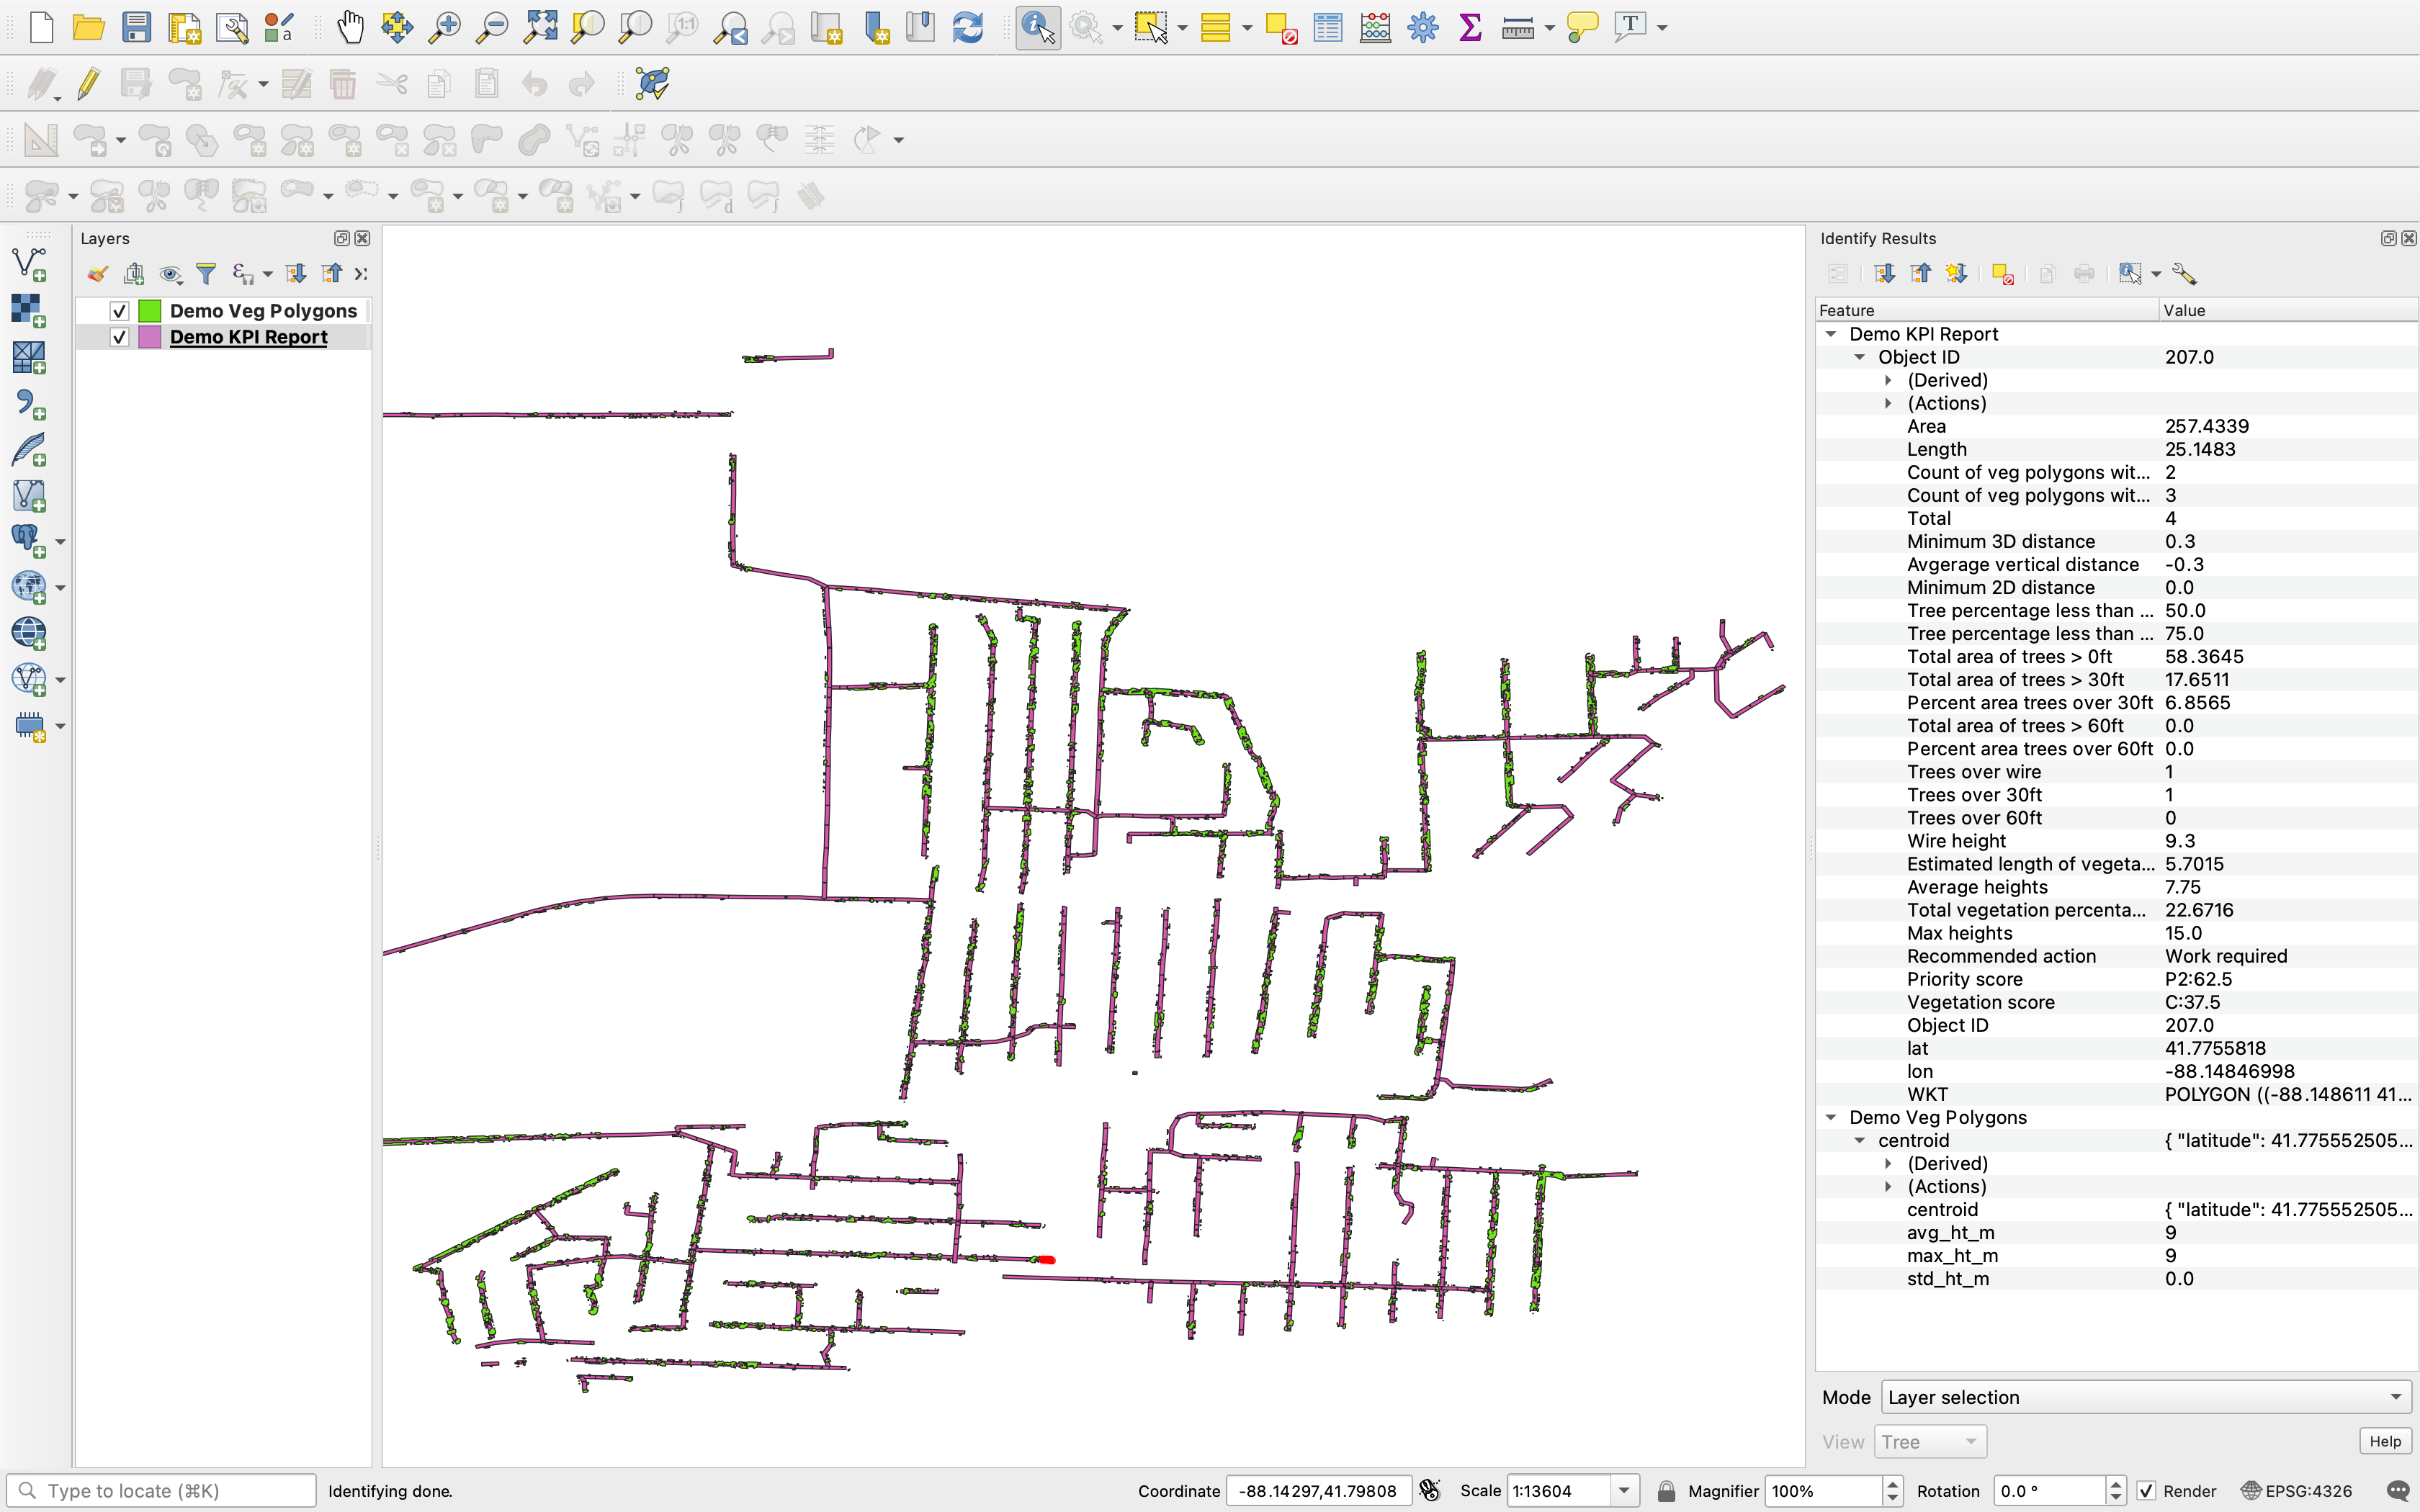

In [24]:
Image('Data/Demo/Demo KPIs and Vegetation.png')

___

___